## Tensorflow Probability - Day 20: Downloading the Geonet dataset  

Today, I won't be doing any tensorflow probability. Things are going really well there and it's time to go get some interesting data that I can start to explore. So I thought I'd get something local and something topical - I went to Geonet's website and started to download NZL earthquake data.

I have manually exported the official measured earthquake data for all 10 regions of NZL for the period 1 Aug 2019 - 1 Nov 2019. I've saved these data as csv files in the Git repository.

To augment the official measurements, Geonet also provide public reports of earthquakes. I think it will be quite interesting to compare the official measurements with the public reportings. We will get these public reports using Geonet's API below.

In [90]:
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mount drive, so that I can save the public reports
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


I've already downloaded the official measurements. We'll read these in from GitHub.

In [0]:
regions = ['auckland', 'bop', 'gisborne', 'hawkesbay', 'taranaki', 'wellington',
           'nelson', 'canterbury', 'fiordland', 'otago']           

url = "https://raw.githubusercontent.com/nickb-/tensorflow-probability-100days/master/data/geonet/{}_earthquakes.csv"

def loader(i,x):
  tmp = pd.read_csv(url.format(x))
  tmp['region'] = x
  tmp['regionid'] = i

  return tmp

geonet = pd.concat(
    [loader(i, x) for i,x in enumerate(regions)]
)
geonet.columns = [x.replace(" ", "") for x in geonet.columns]
geonet.head()

Let's visualise some of these official measurements. I will restruce this to the South Island, because the North Island looks really odd. 

I suspect that the longitude and latitudes might relate to the measurement station which recorded the quake, rather than the epicentre of the quake. I'm not certain of this, and don't know why this would be the case. But, the chart of the North Island quake locations looks a lot like Geonet's chart which shows where seismic stations are located (with incredibly dense coverage over the eastern half of the North Island and very little in the North West of the North Island).

So, here are the official measurements from the South Island:

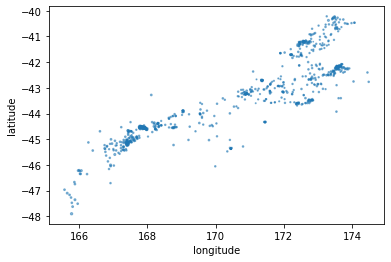

In [0]:
# South Island
geonet[geonet.regionid > 5].plot.scatter(
    'longitude', 'latitude', 
    geonet[geonet.regionid > 5].magnitude, 
    alpha = 0.5
)

We can quite clearly see Fiordland up through the West Coast into Canterbury and Tasman/Marlborough.

Each of these quakes has a `publicid` which we can use to query the reports API and retrieve the public quake reports. Below, is a simple look to gather these.

**NOTE:** I will save these results to the Git repo, so that anyone else can download them from there, rather than swamping Geonet's API :) 

In [0]:
def geonet_mapper(quakeid, response): 

  hits = json.loads(response.content)
  if hits['count'] > 0:

    reported_mmi = hits['count_mmi'].keys()

    summary_schema = pd.DataFrame({
        'publicid': quakeid,
        'TotalCount': hits['count'],
        'mmi1': 0 if '1' not in reported_mmi else hits['count_mmi']['1'],
        'mmi2': 0 if '2' not in reported_mmi else hits['count_mmi']['2'],
        'mmi3': 0 if '3' not in reported_mmi else hits['count_mmi']['3'],
        'mmi4': 0 if '4' not in reported_mmi else hits['count_mmi']['4'],
        'mmi5': 0 if '5' not in reported_mmi else hits['count_mmi']['5'],
        'mmi6': 0 if '6' not in reported_mmi else hits['count_mmi']['6'],
        'mmi7': 0 if '7' not in reported_mmi else hits['count_mmi']['7'],
        'mmi8': 0 if '8' not in reported_mmi else hits['count_mmi']['8'],
        'mmi9': 0 if '9' not in reported_mmi else hits['count_mmi']['9']
    }, index=[0])    
    reports_schema = pd.DataFrame({
        'publicid': quakeid,
        'longitude': [x['geometry']['coordinates'][0] for x in hits['features']],
        'latitude': [x['geometry']['coordinates'][1] for x in hits['features']],
        'total_reports': [x['properties']['count'] for x in hits['features']],
        'mmi': [x['properties']['mmi'] for x in hits['features']]
    })

    return summary_schema, reports_schema

  else:
    return None, None

query = "https://api.geonet.org.nz/intensity?type={}&publicID={}"

results = [
    geonet_mapper(id, requests.get(query.format("reported", id)))
    for id in geonet.publicid
]
report_summary = pd.concat([x for x,y in results if x is not None], ignore_index=True)
reports = pd.concat([y for x,y in results if y is not None], ignore_index = True)

Let's have a look at the public report data. 

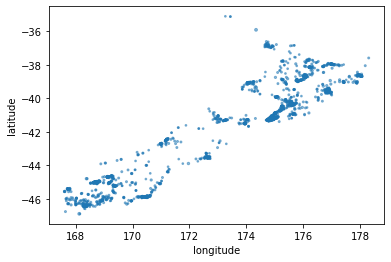

In [72]:
subset_report = reports.query("longitude > 165 & latitude < -30").sample(frac=0.05)

subset_report.plot.scatter('longitude', 'latitude', subset_report.mmi, alpha = 0.5)

There are some very odd locations in these reported data. I wonder where they get the longitude and latitudes from? My suspicion is that Geonet are scraping this from people's IP address. So things like geoblockers and geonormalisation will give dodgy locations. Quite often, our home IP address registers as Auckland or Wellington, even though we are in Nelson. 

Whilst this is annoying from a data-quality perspective, it's pretty cool for my purposes. It gives me some dirty data, some outliers and normal tricky edge cases to deal with. Nice (sort of - ha).

Finally, I will save these data to Google Drive & I will upload this to the Git repo for future use.

In [0]:
reports.to_csv("/content/gdrive/My Drive/DataScience/Projects/TFP/geonet_reported_quakes.csv", index=False)
report_summary.to_csv("/content/gdrive/My Drive/DataScience/Projects/TFP/geonet_reported_quake_summary.csv", index=False)